In [0]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from sklearn.metrics import r2_score
import sys
from numpy import linalg as LA
from keras.utils import to_categorical
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")


import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
import random
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [0]:
def create_dataset(size):
  seq = []
  labels = []
  for i in range(size):
    seq_len = random.randint(100, 110)
    t1 = random.randint(10,20)
    t2 = random.randint(33,43)
    t3 = random.randint(66,76)
    sequence = ""
    order = ""
    label = ""
    for i in range(seq_len):
      if i == 0:
        sequence+="E"
      elif i == seq_len - 1:
        sequence+="B"
      elif i == t1 or i == t2 or i == t3:
        temp = random.choice(['X','Y'])
        order+=temp
        sequence+=temp
      else:
        sequence+=random.choice(['a','b','c','d'])
    if order == "XXX":
          label+="Q"
    if order == "XXY":
        label+="R"
    if order == "XYX":
        label+="S"
    if order == "XYY":
        label+="U"
    if order == "YXX":
        label+="V"
    if order == "YXY":
        label+="A"
    if order == "YYX":
        label+="B"
    if order == "YYY":
        label+="C"
    seq.append(np.array(list(sequence)))
    labels.append(list(label))
  return np.array(seq), np.array(labels)
#one hot encoding
def encoding_sequence(seq):
  sequence = []
  for x in seq:
    y = []
    for i in range(len(x)):    
      if x[i] == "E" or x[i] == "B":
        y.append(int(8))
      elif x[i] == 'X':
        y.append(int(9))
      elif x[i] == 'Y':
        y.append(int(10))
      else:
        y.append(int(11))
    sequence.append(y)
  return sequence

def pre_processed_data(size):
  seq, labels = create_dataset(size)
  seq = encoding_sequence(seq)
  padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(seq,padding='post')
  #one-hot encoding
  encoded_data = [to_categorical(i) for i in padded_inputs]
  encoded_data = np.reshape(np.array(encoded_data),(size,110,12))
  # print(encoded_data.shape)
  #label encoder
  le = preprocessing.LabelEncoder()
  le.fit(labels)
  encoded_labels = le.transform(labels)
  depth = 8
  encoded_labels = tf.one_hot(encoded_labels, depth,
            on_value=1.0, off_value=0.0,
            axis=-1)
  encoded_labels = np.reshape(encoded_labels, (size,8))
  # print(encoded_labels.shape)
  return encoded_data, encoded_labels


def create_batch(n,features,label):
  trainX=[]
  trainY=[]
  randomlist = random.sample(range(0, 3999), n)
  for i in range(len(randomlist)):
    trainX.append(features[i])
    trainY.append(label[i])
  trainX = np.reshape(np.array(trainX),(len(randomlist),12,110))
  trainY = np.reshape(np.array(trainY),(len(randomlist),8))
  return trainX, trainY

def loss(loss_object, model, x, y, training):
  y_ = model(x, training=training)
  return loss_object(y_true=y, y_pred=y_)

def grad(loss_object,model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(loss_object,model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

def train_model(model,encoded_data, encoded_labels):
  loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
  # Keep results for plotting
  train_loss_results = []
  av_training_error = 0
  num_epochs = 0
  while True:
    num_epochs+=1
    epoch_loss_avg = tf.keras.metrics.Mean()
    x,y = create_batch(1,encoded_data,encoded_labels)
    loss_value, grads = grad(loss_object,model,x, y)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    predictions = model(x)
    training_error = LA.norm(predictions - y, 1)
    av_training_error+= ( training_error - av_training_error)/num_epochs
    # Track progress
    epoch_loss_avg.update_state(loss_value)
    # End epoch
    train_loss_results.append(av_training_error)

    if num_epochs % 50 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, Average Training Error: {:.3}, Training error: {:.3f} ".format(num_epochs,
                                                                  epoch_loss_avg.result(),av_training_error,training_error),flush="True")
      sys.stdout.flush()
    if av_training_error < 0.1:
      print("Training Ends")
      print("Epoch {:03d}: Loss: {:.3f}, Average Training Error: {:.3}, Training error: {:.3f} ".format(num_epochs,
                                                                  epoch_loss_avg.result(),av_training_error,training_error),flush="True")
      break

  #plotting training error vs number of sequences passed 
  fig = plt.figure()
  plt.plot(train_loss_results)
  fig.suptitle('Training Error vs Number of Sequences ', fontsize=20)
  plt.xlabel('Number of Sequences', fontsize=18)
  plt.ylabel('Training Error', fontsize=16)
  plt.show()


Epoch 050: Loss: 1.625, Average Training Error: 0.712, Training error: 0.385 
Epoch 100: Loss: 1.322, Average Training Error: 0.431, Training error: 0.056 
Epoch 150: Loss: 1.294, Average Training Error: 0.299, Training error: 0.024 
Epoch 200: Loss: 1.286, Average Training Error: 0.229, Training error: 0.015 
Epoch 250: Loss: 1.283, Average Training Error: 0.186, Training error: 0.010 
Epoch 300: Loss: 1.281, Average Training Error: 0.156, Training error: 0.008 
Epoch 350: Loss: 1.279, Average Training Error: 0.135, Training error: 0.006 
Epoch 400: Loss: 1.278, Average Training Error: 0.119, Training error: 0.005 
Epoch 450: Loss: 1.278, Average Training Error: 0.106, Training error: 0.005 
Training Ends
Epoch 479: Loss: 1.278, Average Training Error: 0.0999, Training error: 0.004 


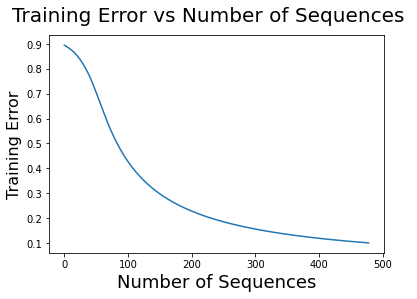

Average Number of missclassification: 2700.0


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(2,return_sequences=True,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=None),unit_forget_bias=False,bias_initializer= 'ones'),
    tf.keras.layers.LSTM(4,return_sequences=True,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=None)),
    tf.keras.layers.LSTM(8,return_sequences=False,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=None)),
    tf.keras.layers.Dense(8, activation='softmax')])
trainx, trainy = pre_processed_data(2000)
train_model(model,trainx,trainy)

#testing 
misclassification = []
for i in range(10):
  misclassify_count=0
  testx,testy = pre_processed_data(3000)
  for j in range(3000):
    x,y = create_batch(1,testx,testy)
    y_pred = model(x)
    error_vector = y_pred - y
    training_error = np.apply_along_axis(LA.norm, 1, error_vector)
    if training_error > 0.3:
      misclassify_count+=1
  misclassification.append(misclassify_count)
print("Average Number of missclassification: "  + str(np.mean(np.array(misclassification))))

Training Ends
Epoch 046: Loss: 1.294, Average Training Error: 0.0993, Training error: 0.023 


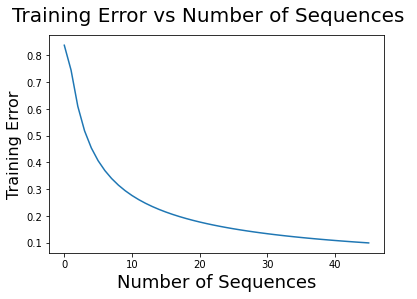

Average Number of missclassification: 2400.0


In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(
    12, activation='tanh',return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(
    10, activation='tanh',return_sequences=False))
model.add(tf.keras.layers.Dense(8,activation='softmax'))


trainx, trainy = pre_processed_data(2000)
train_model(model,trainx,trainy)

#testing 
misclassification = []
for i in range(10):
  misclassify_count=0
  testx,testy = pre_processed_data(3000)
  for j in range(3000):
    x,y = create_batch(1,testx,testy)
    y_pred = model(x)
    error_vector = y_pred - y
    training_error = np.apply_along_axis(LA.norm, 1, error_vector)
    if training_error > 0.3:
      misclassify_count+=1
  misclassification.append(misclassify_count)
print("Average Number of missclassification: "  + str(np.mean(np.array(misclassification))))